In [1]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions (unchanged)
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms (unchanged)
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (with FINDINGS: prefix in __getitem__)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        # <<<— CHANGED: prepend FINDINGS: so model learns after it
        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    # _gen_patches and _clean_report methods as before...
    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function (unchanged)
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition (unchanged)
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p     = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        pf_pooled= self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops (unchanged decode with FINDINGS:)
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p      = pts.view(B*N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_  = model.attn(torch.cat([g,pf],1),
                                torch.cat([g,pf],1),
                                torch.cat([g,pf],1))
            comb    = model.norm(cat)

            # <<<— CHANGED: decode with FINDINGS: prefix
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask= torch.ones_like(prompt_ids, device=device)

            gen_ids = model.decoder.generate(
                input_ids=prompt_ids,
                attention_mask=prompt_mask,
                encoder_hidden_states=comb,
                encoder_attention_mask=torch.ones(B, comb.size(1), device=device),
                max_length=150,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss/len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with freeze/unfreeze
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")
    print(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

# print sample counts
print(f"\nNumber of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")
print(f"Total samples:                {len(train_ds) + len(val_ds) + len(test_ds)}\n")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)

# =============================================================================
# Phase 1: freeze GPT-2 body, train only global_proj, patch_proj, cross-attn
# =============================================================================
for name, p in model.decoder.named_parameters():
    p.requires_grad = False
for p in model.global_proj.parameters():
    p.requires_grad = True
for p in model.patch_proj.parameters():
    p.requires_grad = True
for name, p in model.decoder.named_parameters():
    if "crossattention" in name.lower():
        p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 10
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze entire GPT-2, low‐LR fine‐tune
# =============================================================================
for p in model.decoder.parameters():
    p.requires_grad = True

# rebuild optimizer for full fine-tune
optimizer = optim.AdamW(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 10
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    # build visual context
    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    # generate after FINDINGS: prompt
    prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask= torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


2025-05-15 14:37:06.179164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 14:37:06.185701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747345026.193318  104877 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747345026.195665  104877 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747345026.201555  104877 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60

Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240
Total samples:                2394



Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat


-- Phase 1, Epoch 1/10 --


KeyboardInterrupt: 

## With LoRA

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

LoRA adapters integrated into GPT-2 decoder
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60

Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240
Total samples:                2394


-- Phase 1, Epoch 1/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.7389
  Validation Loss     : 1.1727
  Semantic Similarity : 0.4695

-- Phase 1, Epoch 2/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.4045
  Validation Loss     : 1.1334
  Semantic Similarity : 0.4594

-- Phase 1, Epoch 3/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3389
  Validation Loss     : 1.1222
  Semantic Similarity : 0.5316

-- Phase 1, Epoch 4/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3246
  Validation Loss     : 1.0502
  Semantic Similarity : 0.4444

-- Phase 1, Epoch 5/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2900
  Validation Loss     : 1.0296
  Semantic Similarity : 0.5153

-- Phase 1, Epoch 6/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2707
  Validation Loss     : 1.0290
  Semantic Similarity : 0.4987

-- Phase 1, Epoch 7/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2376
  Validation Loss     : 1.0010
  Semantic Similarity : 0.5078

-- Phase 1, Epoch 8/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2360
  Validation Loss     : 1.0003
  Semantic Similarity : 0.5003

-- Phase 1, Epoch 9/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2010
  Validation Loss     : 0.9974
  Semantic Similarity : 0.5118

-- Phase 1, Epoch 10/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1768
  Validation Loss     : 0.9880
  Semantic Similarity : 0.5196


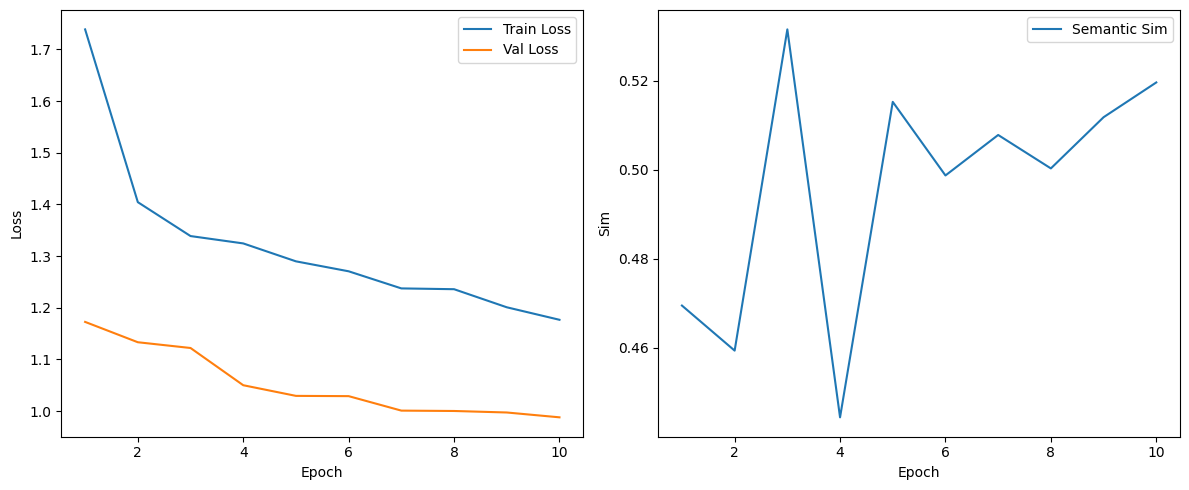


-- Phase 2, Epoch 1/5 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1896
  Validation Loss     : 0.9879
  Semantic Similarity : 0.5092

-- Phase 2, Epoch 2/5 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1787
  Validation Loss     : 0.9895
  Semantic Similarity : 0.5137

-- Phase 2, Epoch 3/5 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1801
  Validation Loss     : 0.9868
  Semantic Similarity : 0.5385

-- Phase 2, Epoch 4/5 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1751
  Validation Loss     : 0.9915
  Semantic Similarity : 0.5217

-- Phase 2, Epoch 5/5 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1793
  Validation Loss     : 0.9859
  Semantic Similarity : 0.5308


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 1.0473
Test Semantic Similarity: 0.4988

--- Example 15 ---
Raw Report       : 
[ Finding ]_x000D_
minimal OA, both knee joints._x000D_
_x000D_
otherwise no significant bony lesion on radiographs._x000D_
_x000D_
[ Conclusion ]_x000D_
minimal OA, both knee joints._x000D_
_x000D_
otherwise no significant bony lesion on radiographs._x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
minimal OA, both knee joints. otherwise no significant bony lesion on radiographs.
Generated Report : 
FINDINGS: degenerative change. 

--- Example 107 ---
Raw Report       : 
[ Finding ]_x000D_
both wrist RA_x000D_
_x000D_
[ Conclusion ]_x000D_
both wrist RA_x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
both wrist RA
Generated Report : 
FINDINGS: no significant bony lesion on radiographs. 

--- Example 67 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
1. Old fracture with bone fragment in lateral portion of

In [3]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# LoRA imports
from peft import LoraConfig, get_peft_model, TaskType

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions (unchanged)
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms (unchanged)
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (with FINDINGS: prefix in __getitem__)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        # <<<— CHANGED: prepend FINDINGS: so model learns after it
        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    # _gen_patches and _clean_report methods as before...
    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function (unchanged)
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition, with LoRA integration
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        # Base GPT-2 decoder
        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

        # Apply LoRA to decoder
        lora_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            r=16,                  # Low rank dimension
            lora_alpha=32,         # Scaling factor
            lora_dropout=0.05,     # Dropout probability
            target_modules=["c_attn", "c_proj"],  # Apply to attention modules
            bias="none"
        )
        self.decoder = get_peft_model(self.decoder, lora_config)
        print("LoRA adapters integrated into GPT-2 decoder")

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p     = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        pf_pooled= self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops (unchanged decode with FINDINGS:)
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p      = pts.view(B*N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_  = model.attn(torch.cat([g,pf],1),
                                torch.cat([g,pf],1),
                                torch.cat([g,pf],1))
            comb    = model.norm(cat)

            # <<<— CHANGED: decode with FINDINGS: prefix
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask= torch.ones_like(prompt_ids, device=device)

            gen_ids = model.decoder.generate(
                input_ids=prompt_ids,
                attention_mask=prompt_mask,
                encoder_hidden_states=comb,
                encoder_attention_mask=torch.ones(B, comb.size(1), device=device),
                max_length=150,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss/len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with freeze/unfreeze
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# instantiate model (with LoRA built in)
model = MultiModalModel().to(device)

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")
    print(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

# print sample counts
print(f"\nNumber of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")
print(f"Total samples:                {len(train_ds) + len(val_ds) + len(test_ds)}\n")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# =============================================================================
# Phase 1: freeze base GPT-2 and train only LoRA + vision adapters
# =============================================================================
for name, p in model.decoder.base_model.named_parameters():
    p.requires_grad = False
# LoRA adapters remain trainable automatically
for p in model.global_proj.parameters():
    p.requires_grad = True
for p in model.patch_proj.parameters():
    p.requires_grad = True
for name, p in model.decoder.named_parameters():
    if "crossattention" in name.lower():
        p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 10
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze LoRA adapters only (keep base GPT-2 frozen)
# =============================================================================
for name, p in model.decoder.base_model.named_parameters():
    p.requires_grad = False
# LoRA adapters still trainable

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 5
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    # build visual context
    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    # generate after FINDINGS: prompt
    prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask= torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

LoRA adapters integrated into GPT-2 decoder
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60

Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240
Total samples:                2394


-- Phase 1, Epoch 1/1 --


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]         

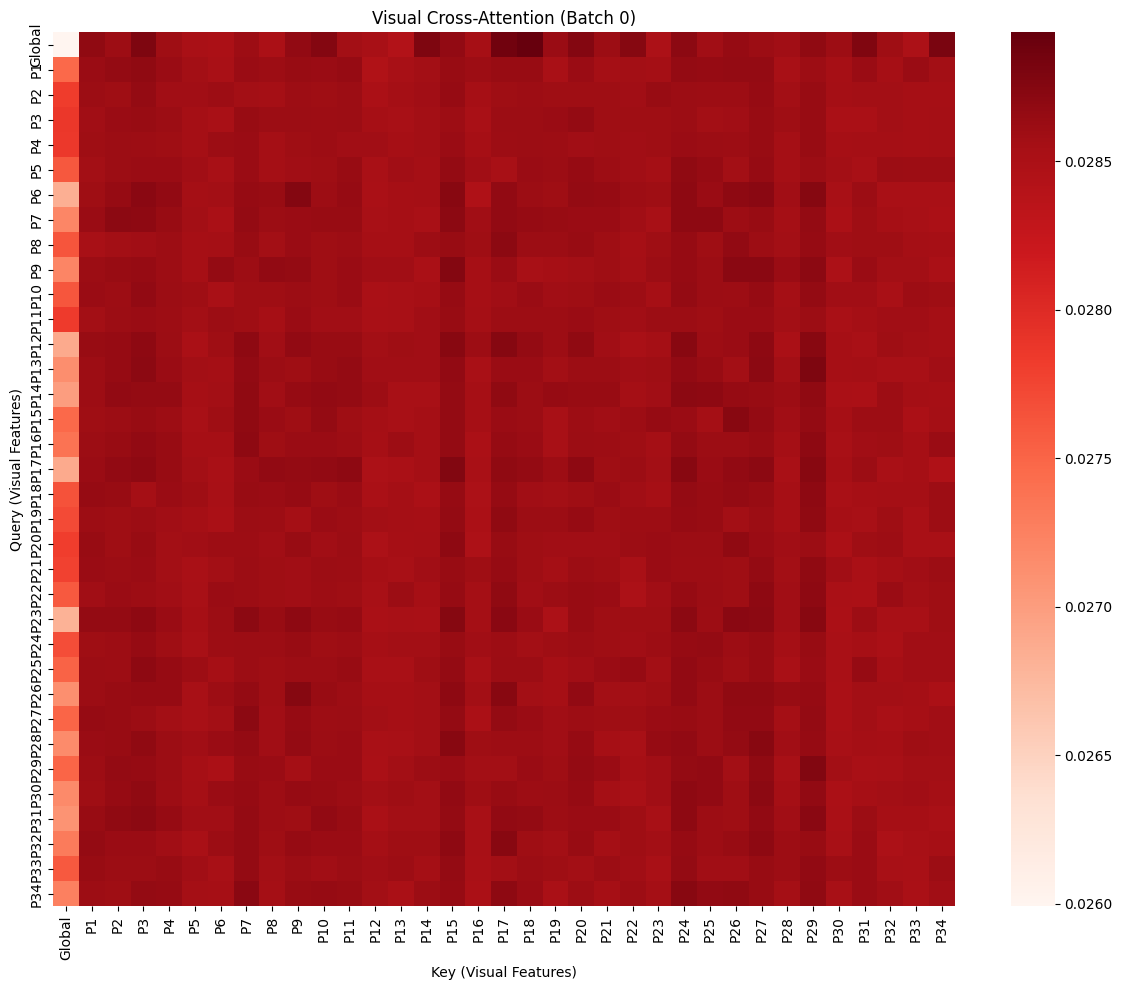

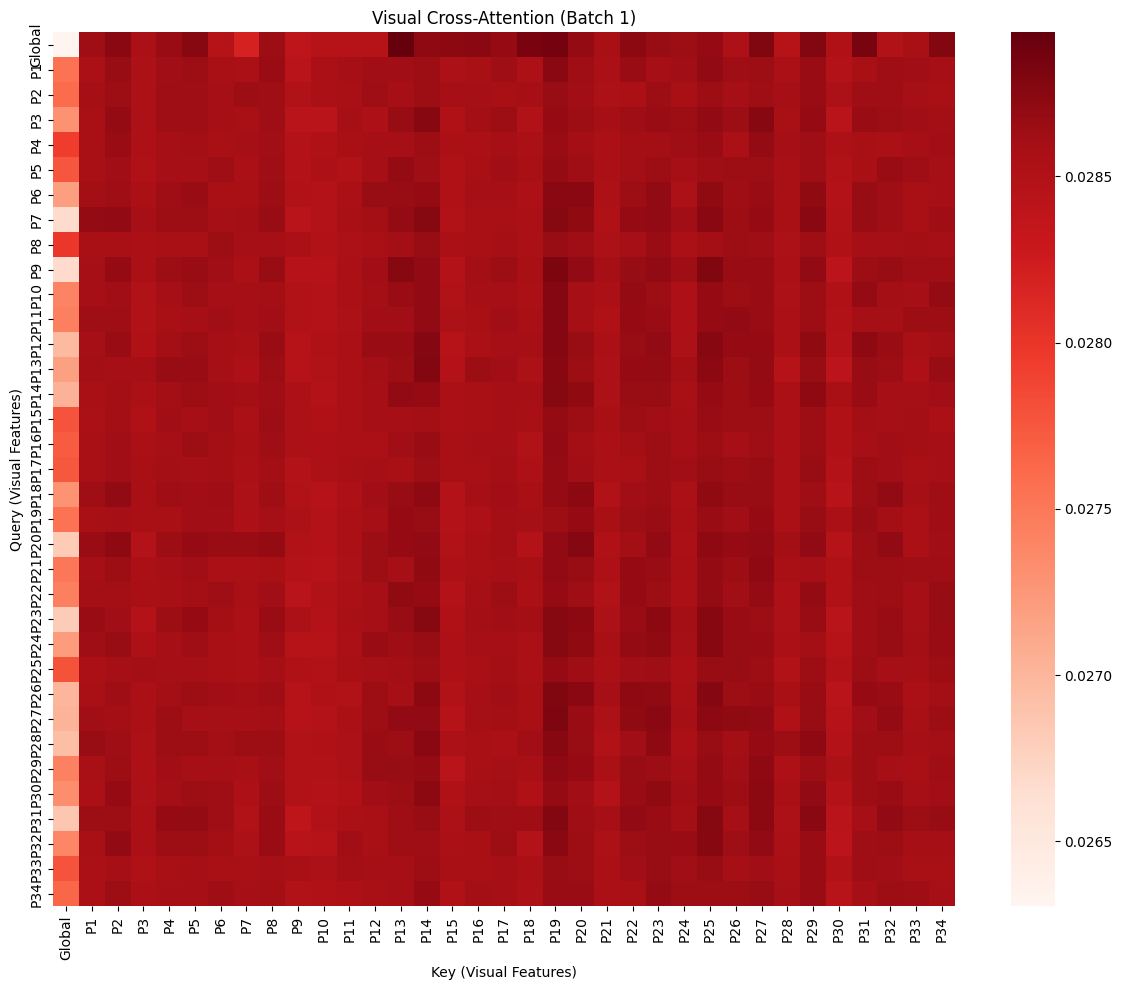

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 2.2431
  Validation Loss     : 1.3322
  Semantic Similarity : 0.4416


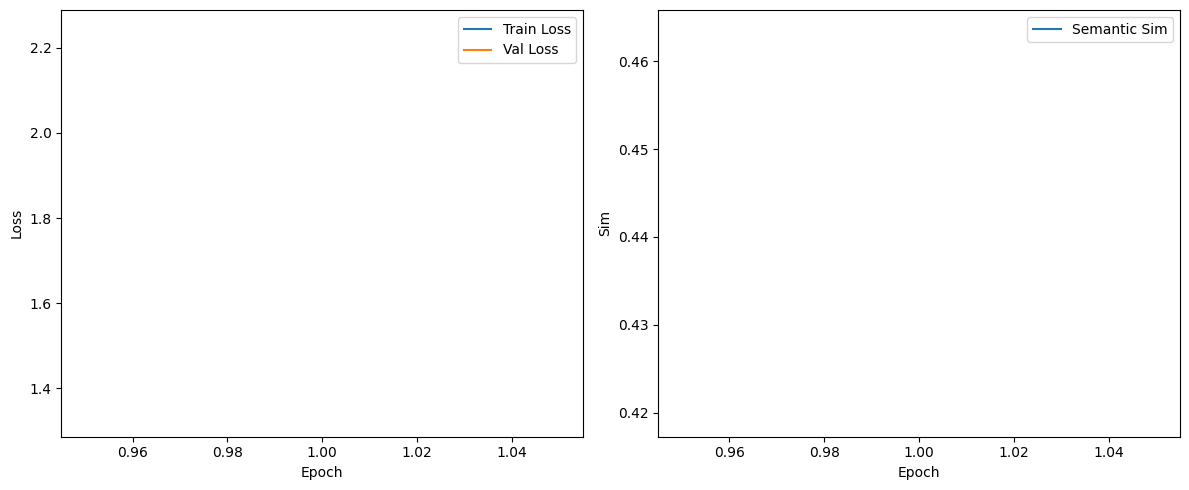

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

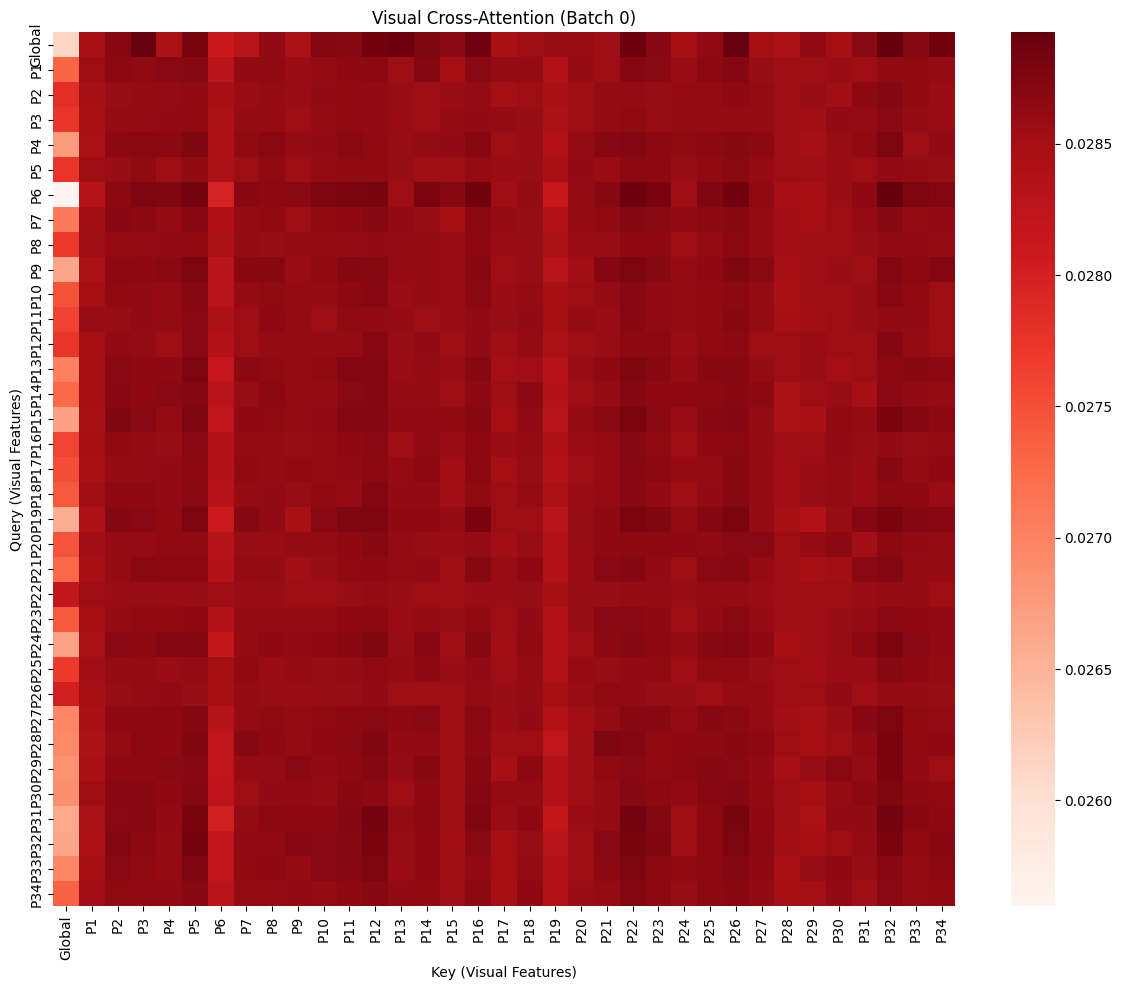

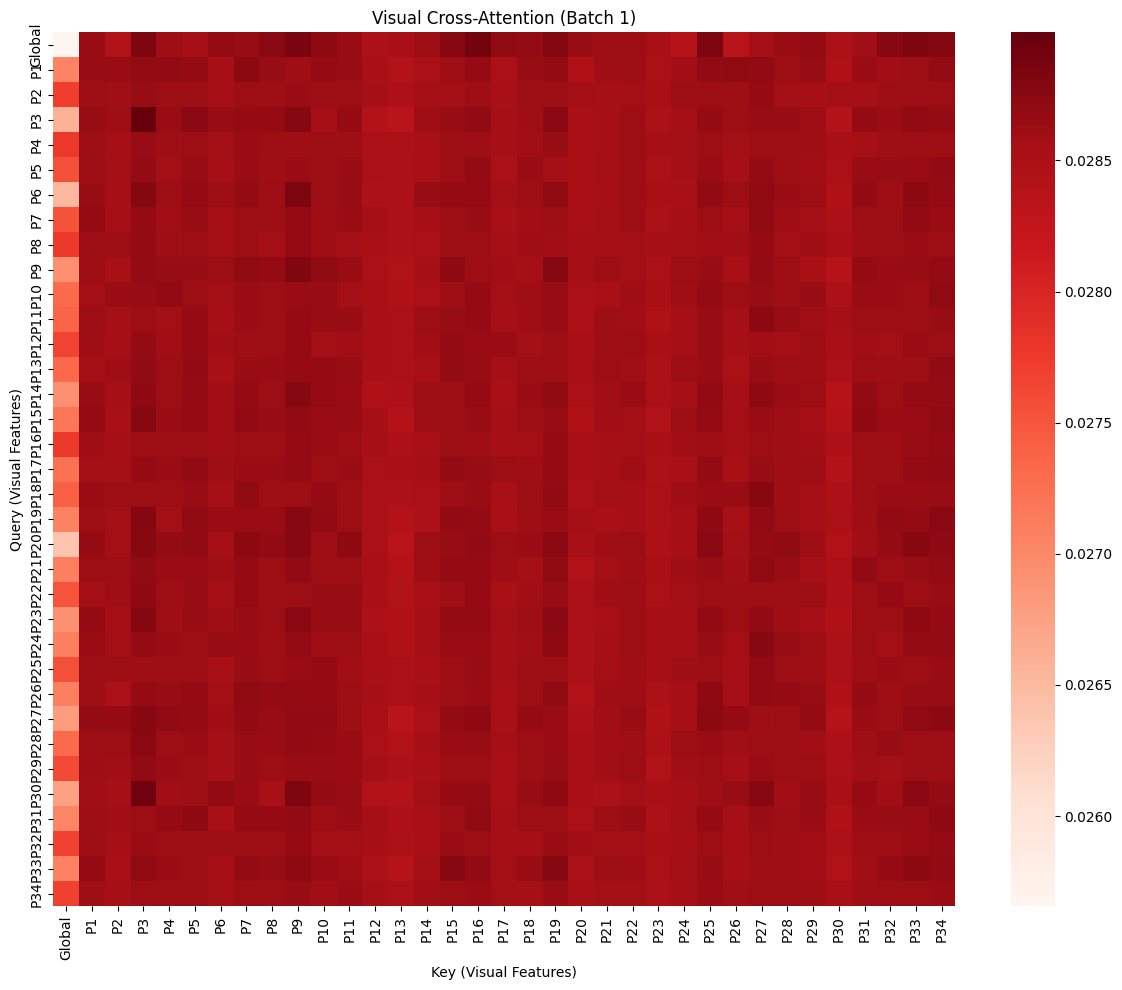

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 1.3384
Test Semantic Similarity: 0.4569

========== VISUALIZING CROSS-ATTENTION ==========


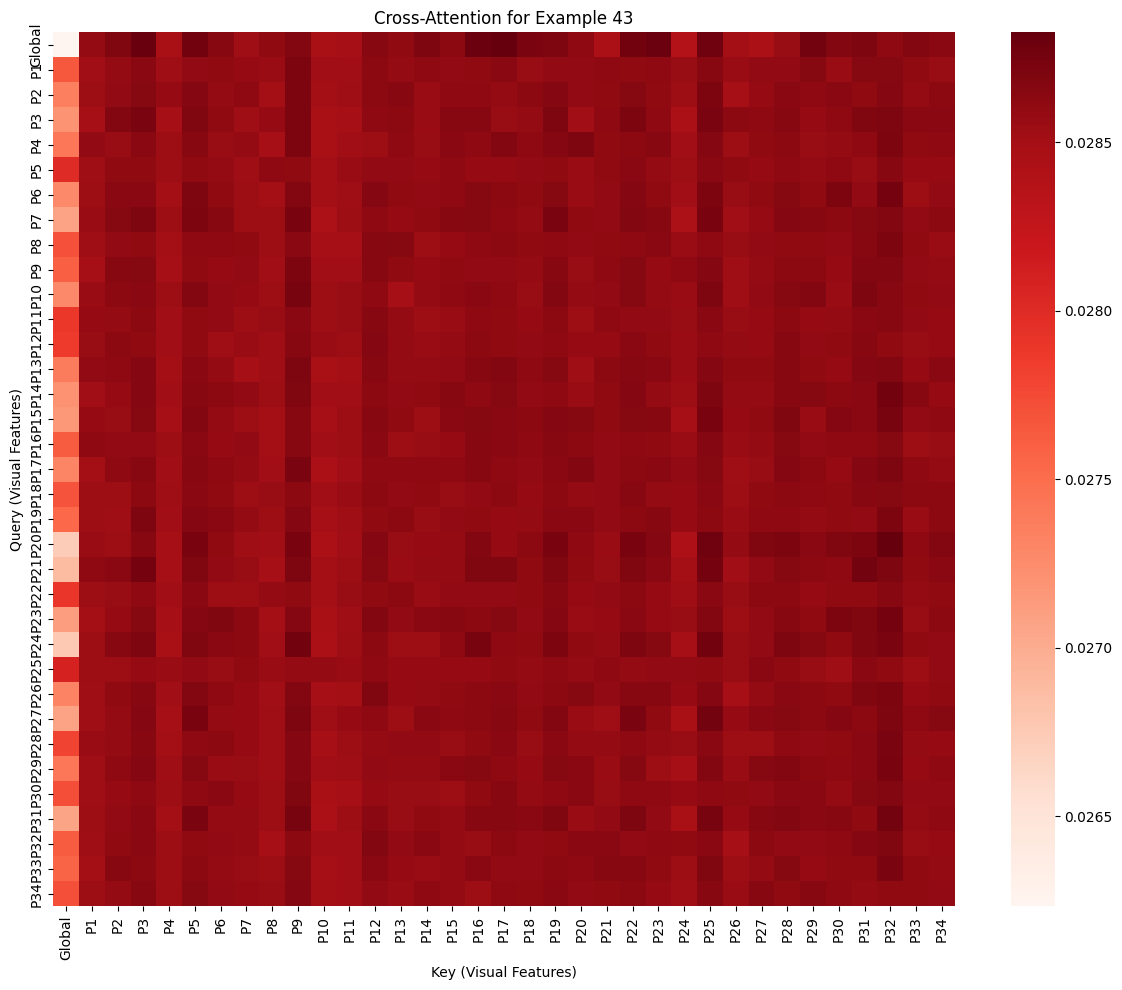

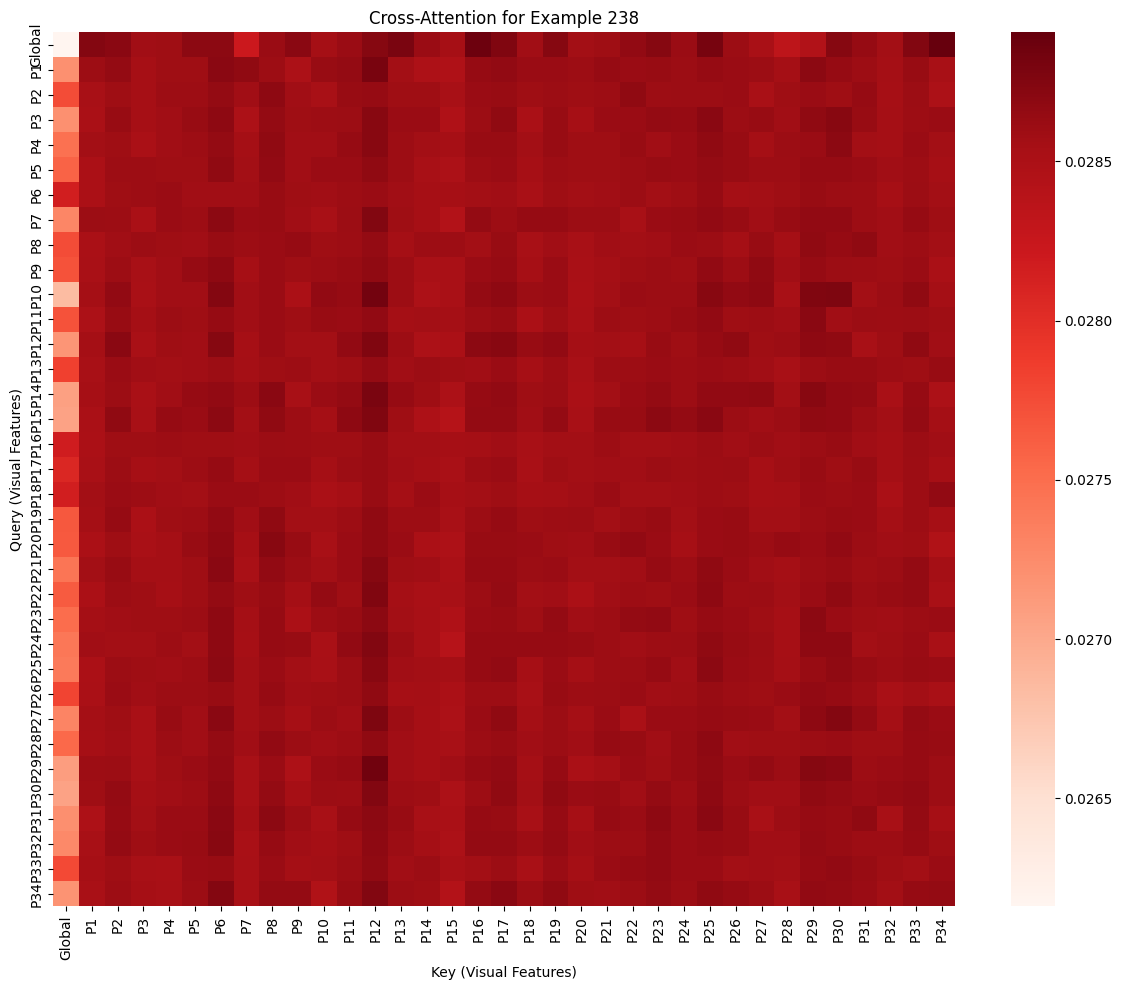

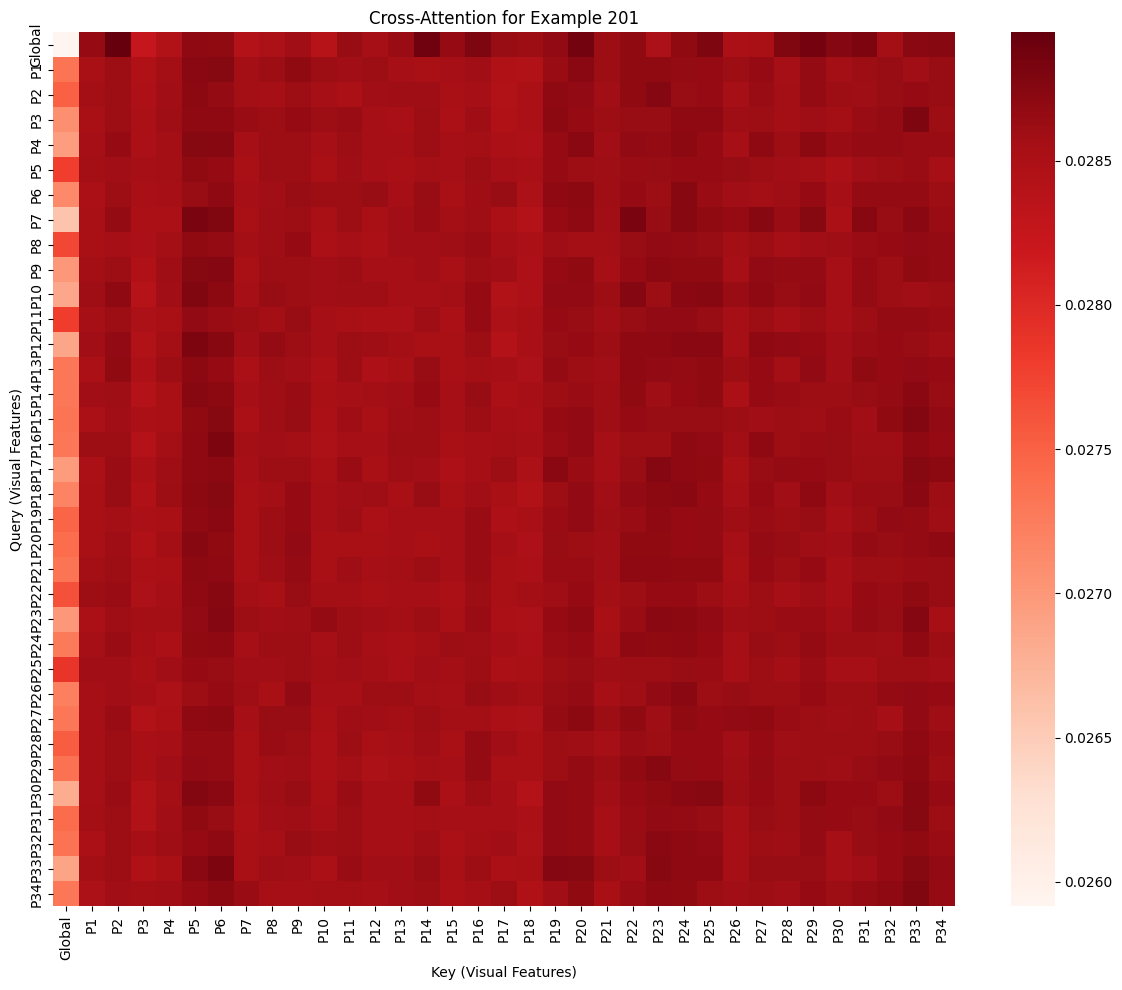

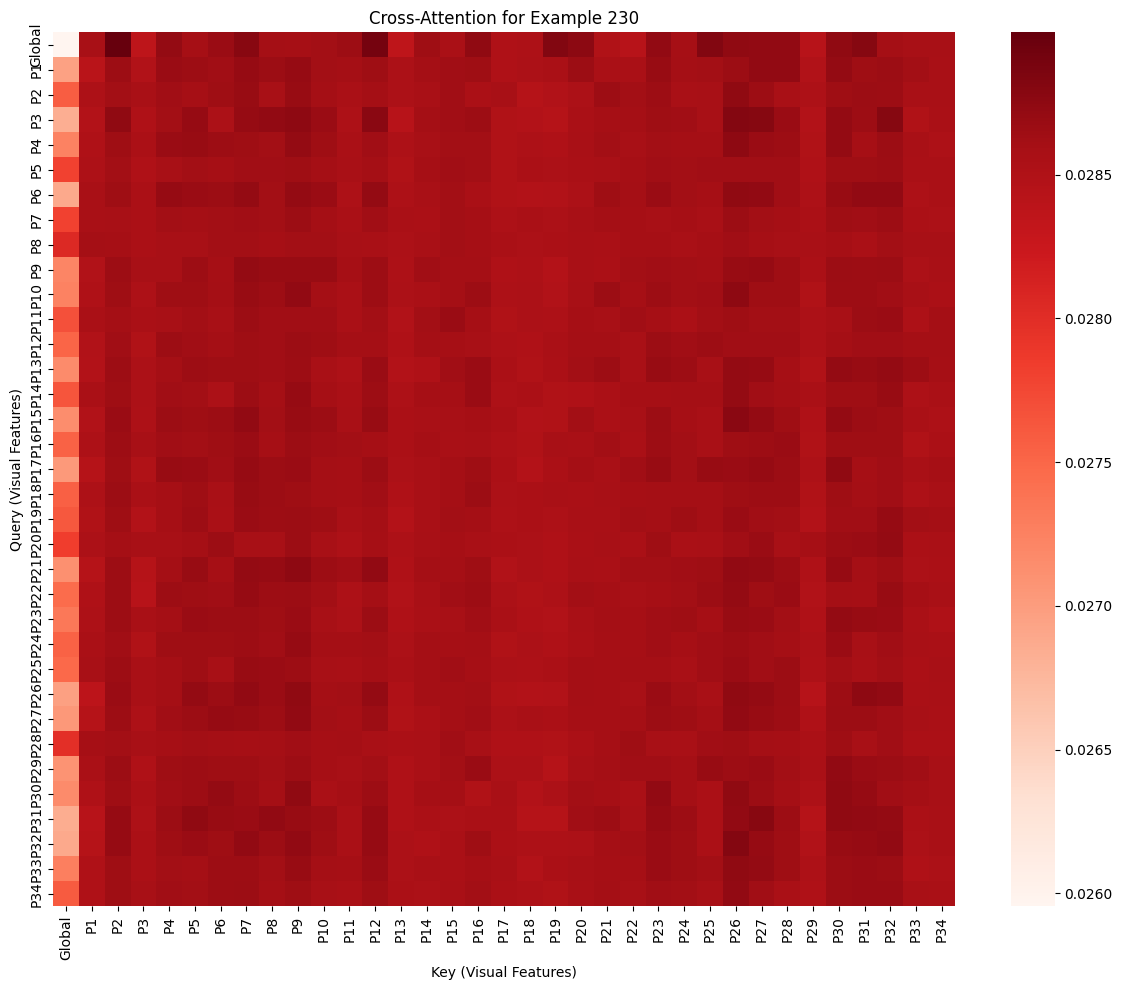

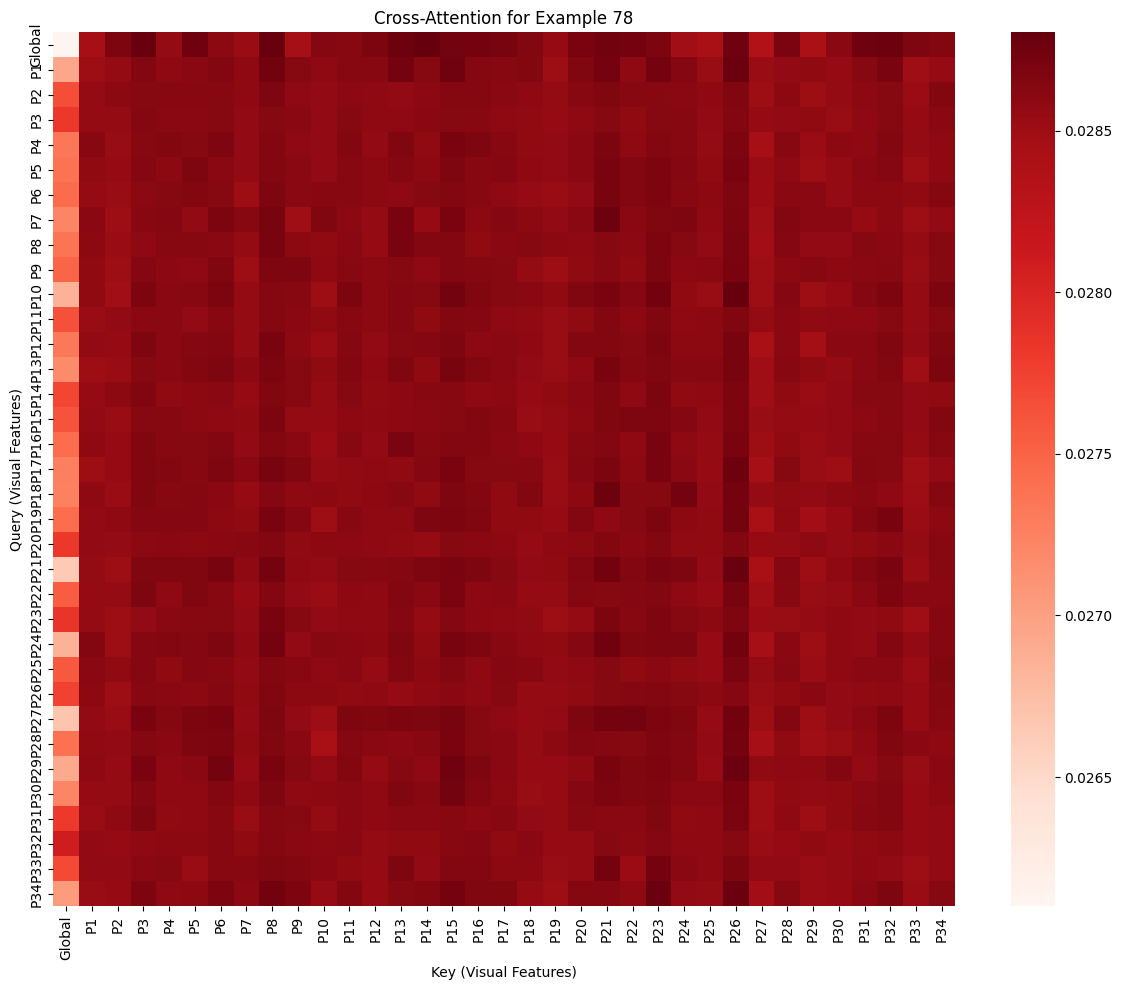


Visualizing decoder cross-attention...


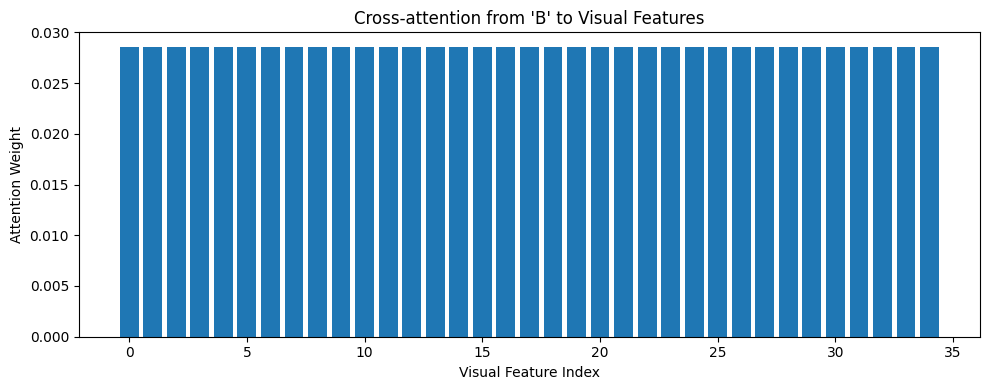


--- Example 237 ---
Raw Report       : 
[ Finding ]_x000D_
degenerative change._x000D_
[ Conclusion ]_x000D_
degenerative change._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
degenerative change.
Generated Report : 
FINDINGS: degenerative change in both right quadricular joint. 

--- Example 70 ---
Raw Report       : 
[ Finding ]_x000D_
no bony lesion._x000D_
[ Conclusion ]_x000D_
no bony lesion._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
no bony lesion.
Generated Report : 
FINDINGS: degenerative change. 

--- Example 0 ---
Raw Report       : 
[FINDING       ]_x000D_R/O gout arthritis, both feet and hands.
both 1st toe and finger, intramedullary scleoritc lesions
  --> R/O bone infarction_x000D__x000D_[CONCLUSION    ]_x000D_R/O gout arthritis, both feet and hands.
both 1st toe and finger, intramedullary scleoritc lesions
  --> R/O bone infarction_x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report   : 
R/O gout arthritis, both feet and hands. both 1st toe and finger, intram

In [20]:
import os
import re
import json
import unicodedata
import random
import logging
import seaborn as sns
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# LoRA imports
from peft import LoraConfig, get_peft_model, TaskType

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions (unchanged)
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms (unchanged)
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

def visualize_attention(attn_weights, title="Attention Weights", filename=None):
    """
    Visualize attention weights as a heatmap.
    
    Args:
        attn_weights: Tensor of attention weights
        title: Plot title
        filename: Optional filename to save the plot
    """
    plt.figure(figsize=(12, 10))
    
    # Convert to numpy for plotting
    attn = attn_weights.detach().cpu().numpy()

    
    # Plot heatmap
    sns.heatmap(attn, cmap="Reds")
    
    # Add labels for global image and patches
    n_features = attn.shape[0]
    feature_labels = ["Global"] + [f"P{i}" for i in range(1, n_features)]
    plt.xticks(np.arange(n_features) + 0.5, feature_labels, rotation=90)
    plt.yticks(np.arange(n_features) + 0.5, feature_labels)
    
    plt.title(title)
    plt.xlabel("Key (Visual Features)")
    plt.ylabel("Query (Visual Features)")
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.show()

def visualize_decoder_cross_attention(model, example, tokenizer, device):
    """
    Correctly extract decoder cross‐attention and plot
    the attention from the first real token ("F") to all
    visual features.
    """
    # Prepare inputs
    fi = example['full_img'].unsqueeze(0).to(device)
    pa = example['patches'].unsqueeze(0).to(device)
    prompt = "[BOS] FINDINGS:"              # match what your dataset uses
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    # Build visual context
    with torch.no_grad():
        # encode vision
        g_feats = model.global_encoder(fi)
        g = model.global_proj(g_feats).unsqueeze(1)
        B,N,C,H,W = pa.shape
        p = pa.view(B*N, C, H, W)
        pf_feats = model.patch_encoder(p)
        pf_pooled = model._pool(pf_feats)
        pf = model.patch_proj(pf_pooled).view(B, N, 768)
        cat, _ = model.attn(torch.cat([g,pf],1),
                            torch.cat([g,pf],1),
                            torch.cat([g,pf],1),
                            need_weights=False)
        encoder_hidden_states = model.norm(cat)

        # decode with cross‐attention
        outputs = model.decoder(
            input_ids=input_ids,
            encoder_hidden_states=encoder_hidden_states,
            output_attentions=True,
            return_dict=True
        )

        # outputs.cross_attentions is a tuple of length L, each (B, H, Q, K)
        # stack and average over layers & heads:
        #   cross: (L, B, H, Q, K)
        cross = torch.stack(outputs.cross_attentions, dim=0)
        # average over layers (dim=0) and heads (dim=2) → (B, Q, K)
        cross = cross.mean(dim=0).mean(dim=1)

        # pick batch 0, query index = 1 (the "F" after [BOS])
        token_idx = 1
        attn_to_feats = cross[0, token_idx]  # shape (K,)

        # Plot bar chart
        plt.figure(figsize=(10,4))
        plt.bar(range(attn_to_feats.size(0)),
                attn_to_feats.cpu().numpy())
        plt.xlabel("Visual Feature Index")
        plt.ylabel("Attention Weight")
        plt.title(f"Cross‐attention from '{tokenizer.decode(input_ids[0,token_idx])}' to Visual Features")
        plt.tight_layout()
        plt.show()



# =============================================================================
# Dataset (with FINDINGS: prefix in __getitem__)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        # <<<— CHANGED: prepend FINDINGS: so model learns after it
        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    # _gen_patches and _clean_report methods as before...
    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function (unchanged)
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition, with LoRA integration
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        # Base GPT-2 decoder
        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

        # Apply LoRA to decoder
        lora_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            r=16,                  # Low rank dimension
            lora_alpha=32,         # Scaling factor
            lora_dropout=0.05,     # Dropout probability
            target_modules=["c_attn", "c_proj"],  # Apply to attention modules
            bias="none"
        )
        self.decoder = get_peft_model(self.decoder, lora_config)
        print("LoRA adapters integrated into GPT-2 decoder")

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None, visualize_attn=False):
        g_feats = self.global_encoder(imgs)
        g = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                   if hasattr(self.patch_encoder, 'forward_features')
                   else self.patch_encoder(p))
        pf_pooled = self._pool(pf_feats)
        pf = self.patch_proj(pf_pooled).view(B, N, 768)

        # Modified to get attention weights with need_weights=True
        cat, attn_weights = self.attn(torch.cat([g,pf],1),
                                     torch.cat([g,pf],1),
                                     torch.cat([g,pf],1),
                                     need_weights=True)
        
        # Visualize attention if requested
        if visualize_attn:
            for b in range(min(B, 2)):  # Visualize first 2 examples maximum
                visualize_attention(
                    attn_weights[b],
                    title=f"Visual Cross-Attention (Batch {b})",
                    filename=f"visual_attention_batch_{b}.png"
                )
        
        comb = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        # Return attention weights along with model output
        return out, attn_weights

# =============================================================================
# Training & evaluation loops (unchanged decode with FINDINGS:)
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out, _ = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device, visualize_attn=True):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    visualization_done = False
    
    for b_idx, b in enumerate(tqdm(loader, desc="Evaluating", leave=False)):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            # Only visualize the first batch
            visualize_this_batch = visualize_attn and not visualization_done
            out, attn_weights = model(imgs, pts, ids, msk, decoder_labels=ids, 
                                     visualize_attn=visualize_this_batch)
            
            if visualize_this_batch:
                visualization_done = True
            
            total_loss += out.loss.item()

            # Continue with existing code for generation
            g_feats = model.global_encoder(imgs)
            g = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p = pts.view(B*N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled = model._pool(pf_feats)
            pf = model.patch_proj(pf_pooled).view(B, N, 768)
            cat, _ = model.attn(torch.cat([g,pf],1),
                              torch.cat([g,pf],1),
                              torch.cat([g,pf],1))
            comb = model.norm(cat)
            
            # <<<— CHANGED: decode with FINDINGS: prefix
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask= torch.ones_like(prompt_ids, device=device)

            gen_ids = model.decoder.generate(
                input_ids=prompt_ids,
                attention_mask=prompt_mask,
                encoder_hidden_states=comb,
                encoder_attention_mask=torch.ones(B, comb.size(1), device=device),
                max_length=150,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss/len(loader), all_gen, all_gt


def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with freeze/unfreeze
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# instantiate model (with LoRA built in)
model = MultiModalModel().to(device)

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")
    print(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

# print sample counts
print(f"\nNumber of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")
print(f"Total samples:                {len(train_ds) + len(val_ds) + len(test_ds)}\n")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# =============================================================================
# Phase 1: freeze base GPT-2 and train only LoRA + vision adapters
# =============================================================================
for name, p in model.decoder.base_model.named_parameters():
    if "crossattention" not in name:
        p.requires_grad = False

# 3) Ensure vision projections stay trainable
for p in model.global_proj.parameters():
    p.requires_grad = True
for p in model.patch_proj.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 1
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze LoRA adapters only (keep base GPT-2 frozen)
# =============================================================================
for name, p in model.decoder.base_model.named_parameters():
    p.requires_grad = False

# 2) Freeze vision projections
for p in model.global_proj.parameters():
    p.requires_grad = False
for p in model.patch_proj.parameters():
    p.requires_grad = False

# 3) Un-freeze only the LoRA adapters (they live in model.decoder)
for name, p in model.decoder.named_parameters():
    if "lora" in name.lower():
        p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 0
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# In your test examples section, add:
print("\n========== VISUALIZING CROSS-ATTENTION ==========")
for i, idx in enumerate(random.sample(range(len(test_ds)), min(5, len(test_ds)))):
    ex = test_ds[idx]
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)

    # Extract visual features
    g_feats = model.global_encoder(fi)
    g = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p = pa.view(B*N, C, H, W)
    pf_feats = model.patch_encoder(p)
    pf_pooled = model._pool(pf_feats)
    pf = model.patch_proj(pf_pooled).view(B,N,768)
    
    # Get attention weights and visualize
    cat, attn_weights = model.attn(
        torch.cat([g,pf],1),
        torch.cat([g,pf],1),
        torch.cat([g,pf],1),
        need_weights=True
    )
    
    visualize_attention(
        attn_weights[0],  # First batch item
        title=f"Cross-Attention for Example {idx}",
        filename=f"example_{idx}_attention.png"
    )
    
    # Continue with existing code...
# Add to your test section
print("\nVisualizing decoder cross-attention...")
example_idx = random.choice(range(len(test_ds)))
visualize_decoder_cross_attention(model, test_ds[example_idx], tokenizer, device)


# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    # build visual context
    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    # generate after FINDINGS: prompt
    prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask= torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

LoRA adapters integrated into GPT-2 decoder
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60

Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240
Total samples:                2394


-- Phase 1, Epoch 1/1 --


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]         

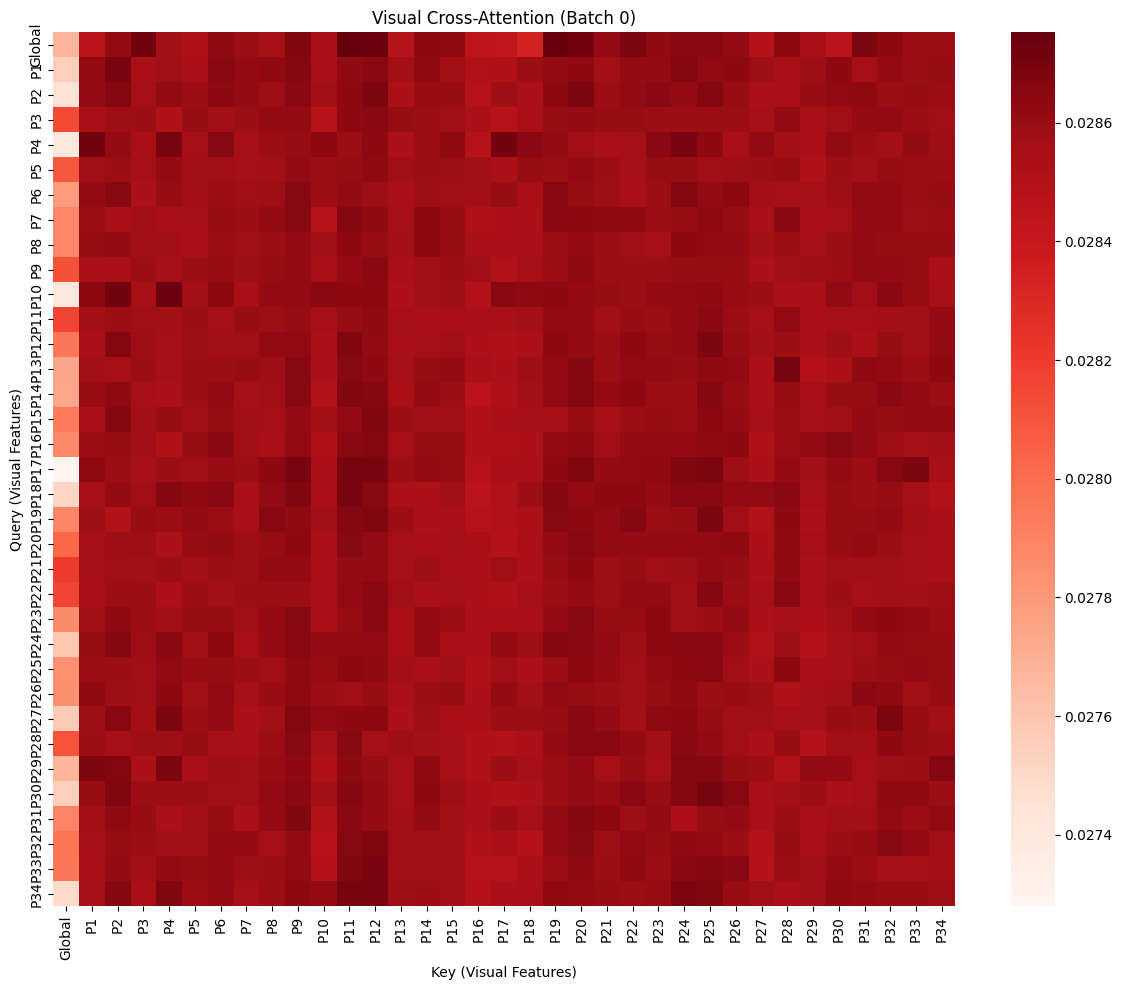

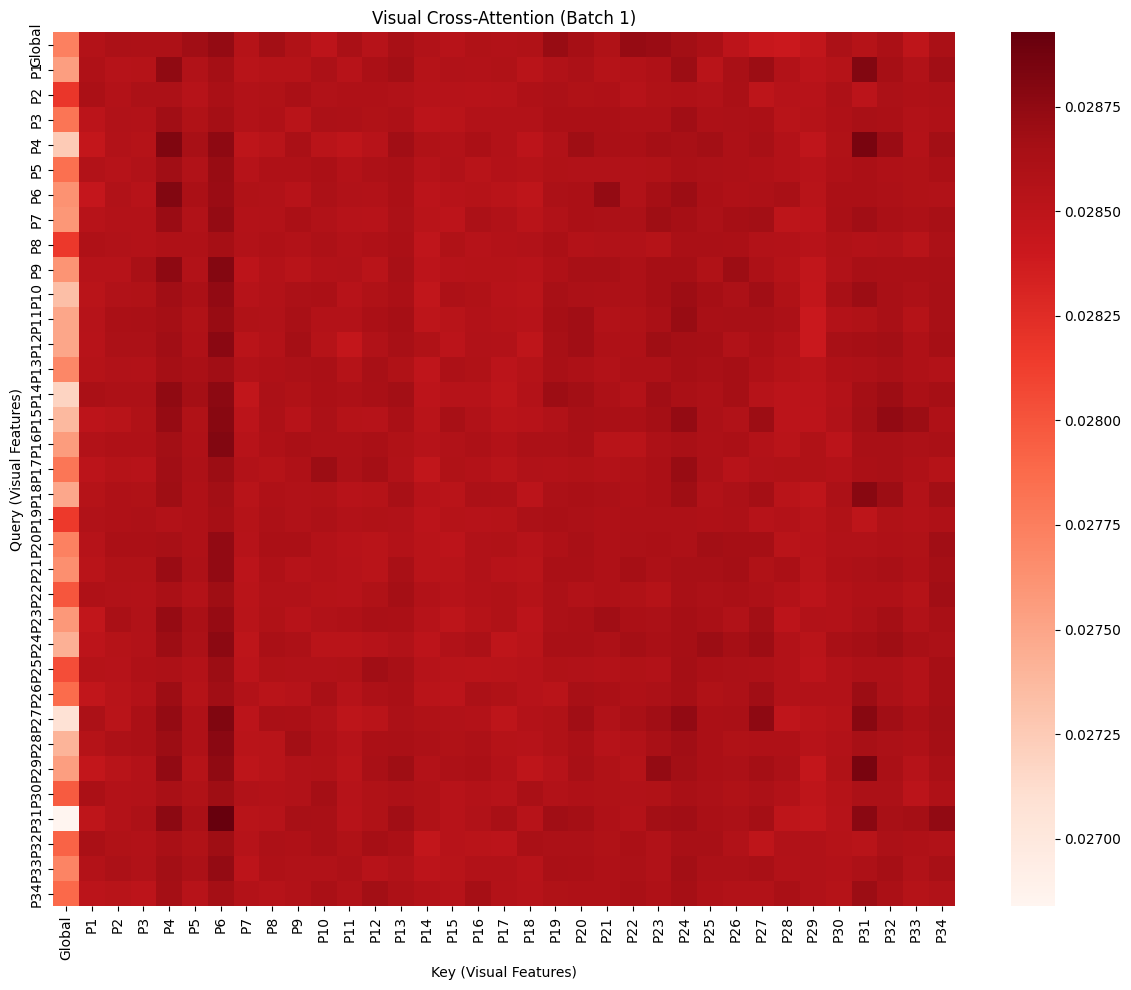

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3281
  Validation Loss     : 0.8991
  Semantic Similarity : 0.4222


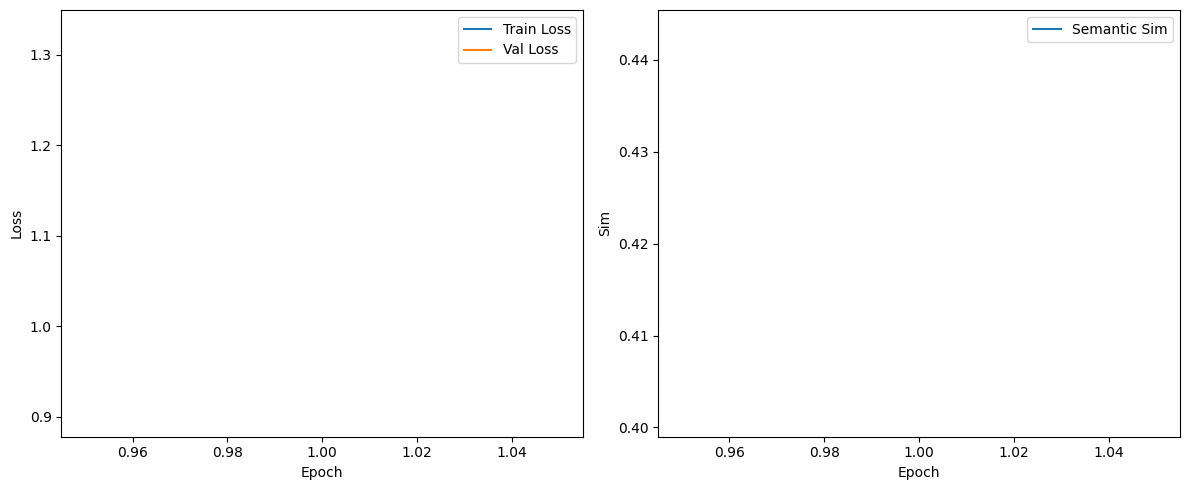


-- Phase 2, Epoch 1/1 --


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]         

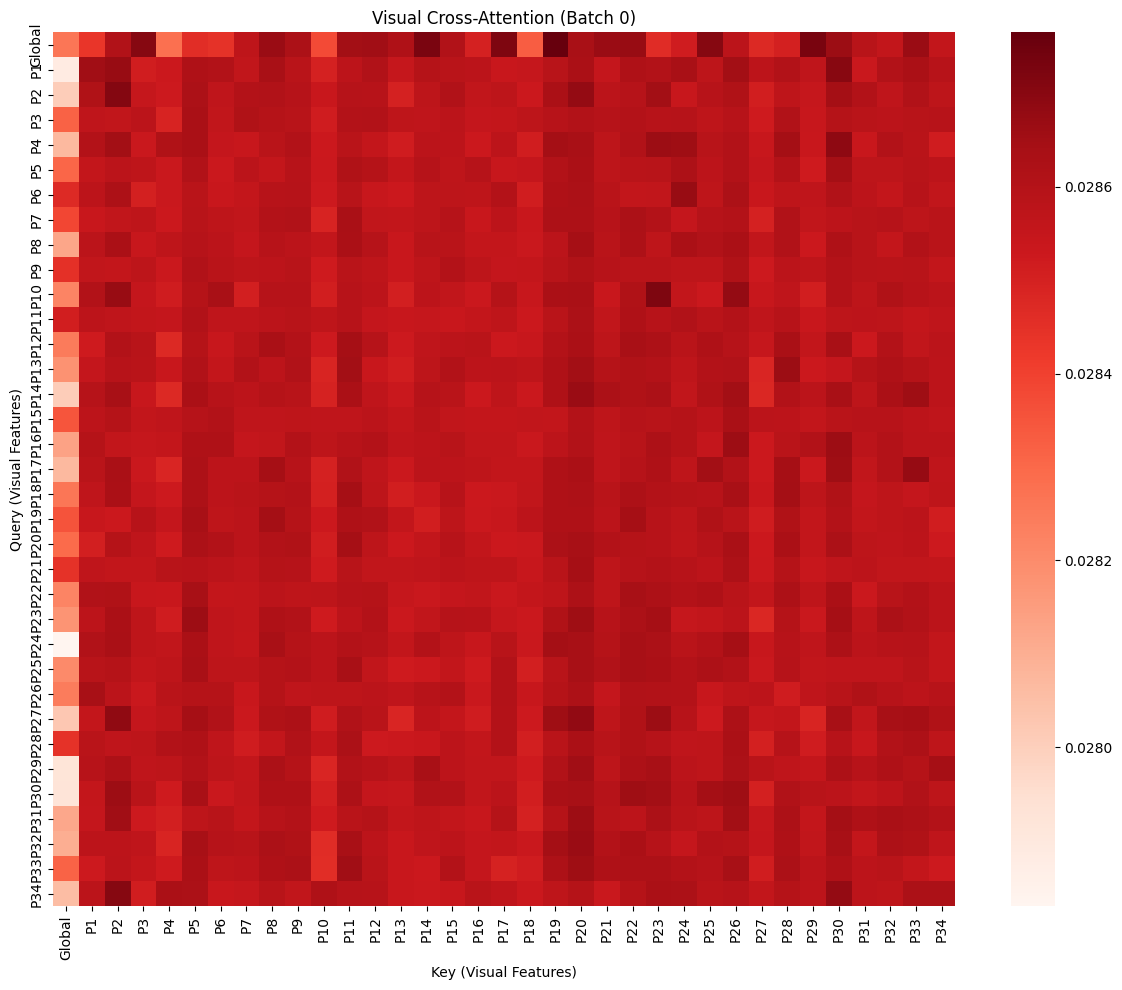

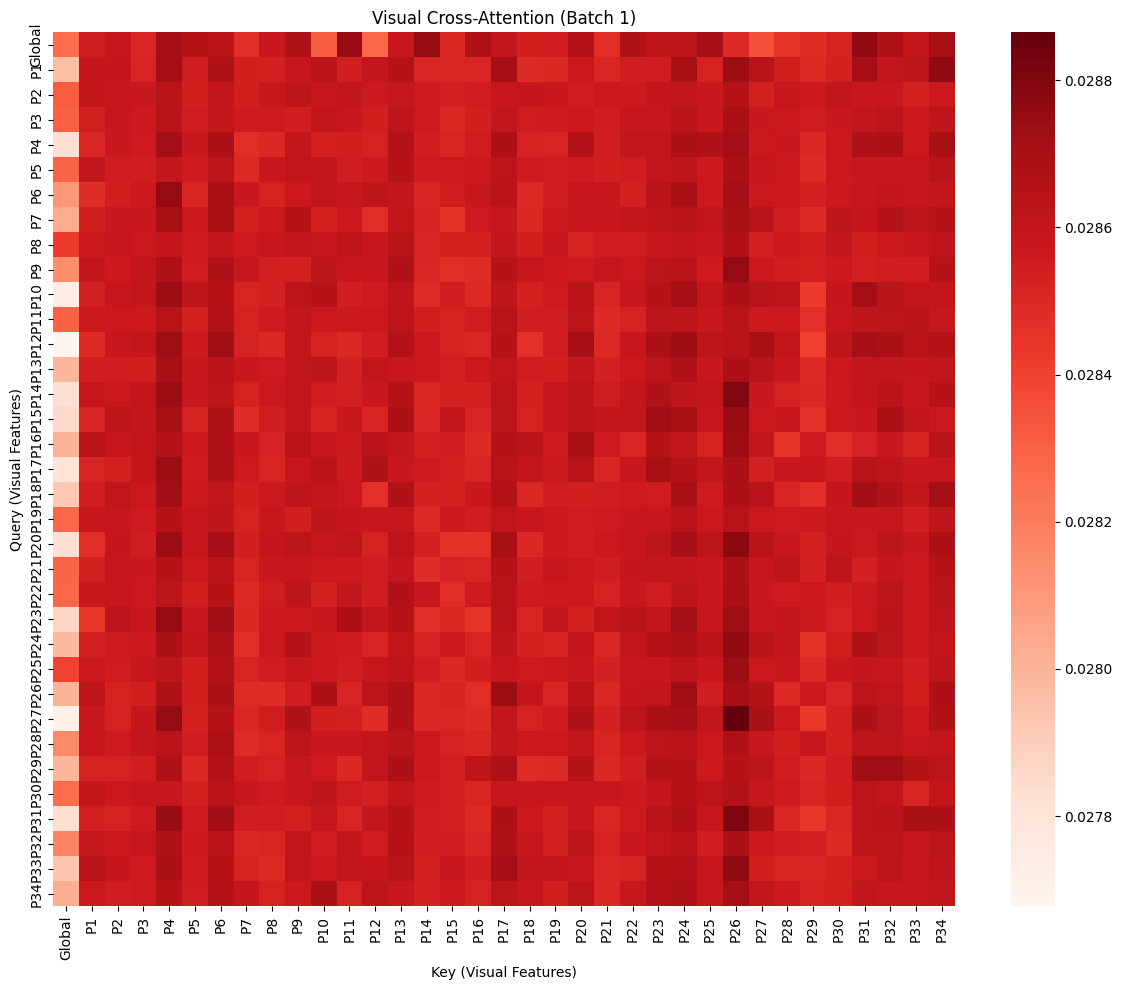

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.9452
  Validation Loss     : 0.8888
  Semantic Similarity : 0.4621


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

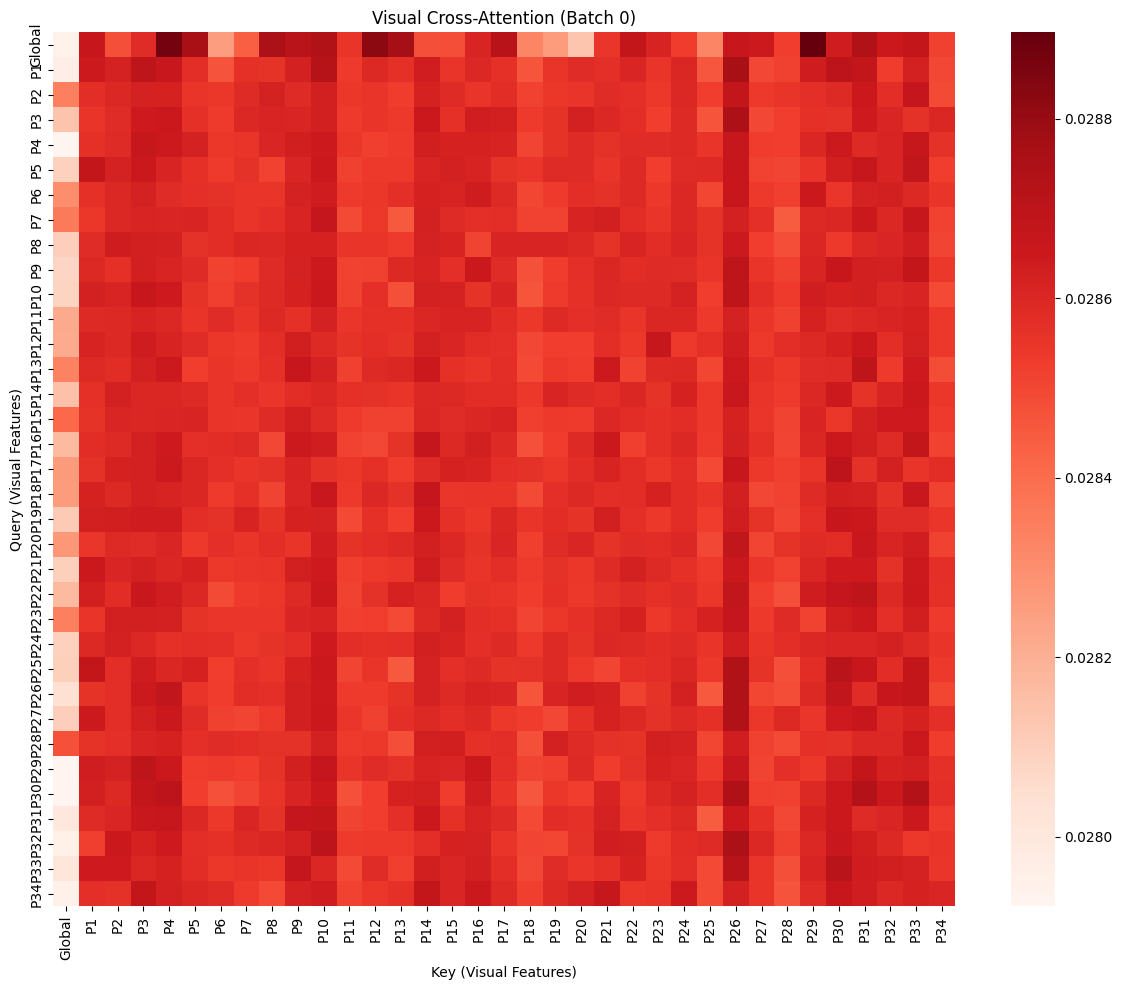

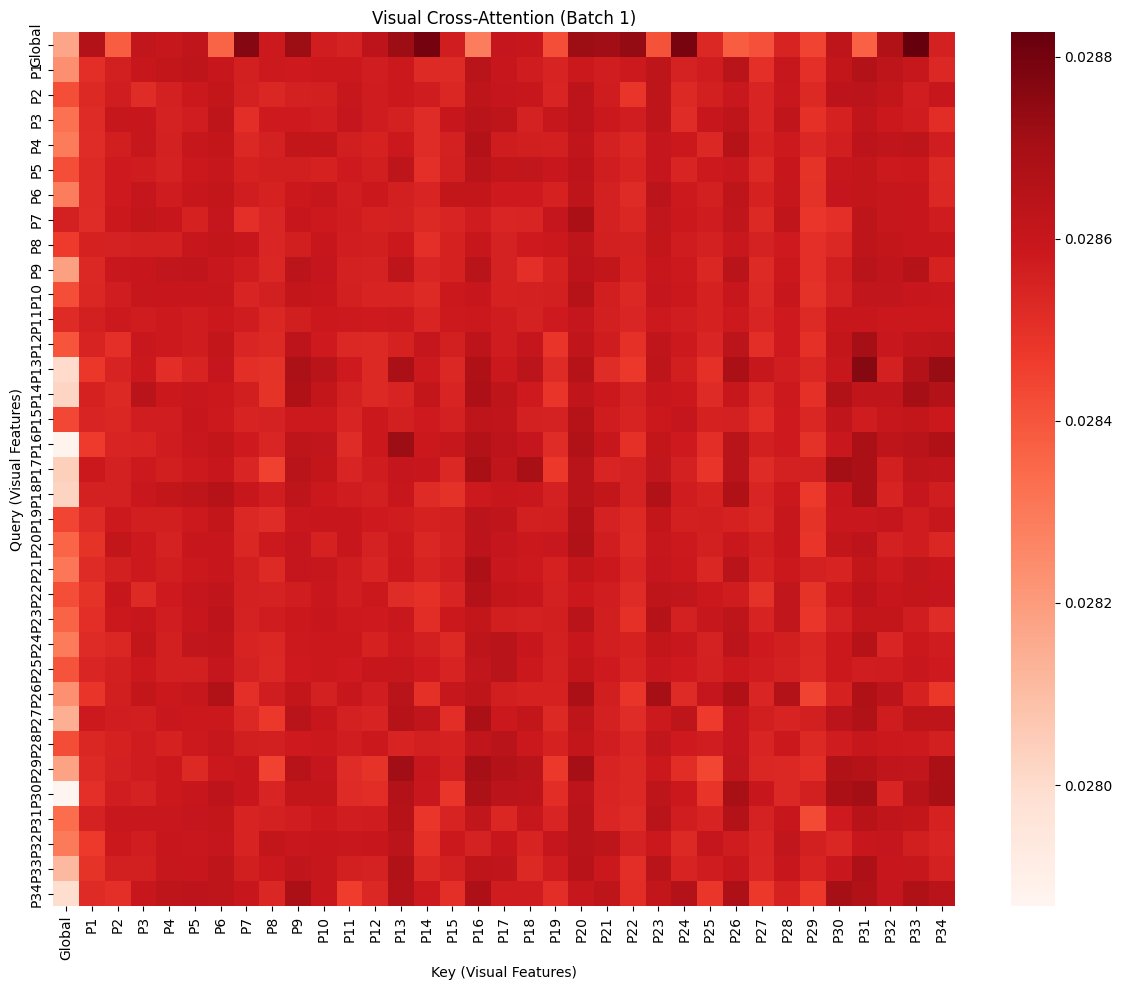

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 0.8632
Test Semantic Similarity: 0.4730

========== VISUALIZING CROSS-ATTENTION ==========


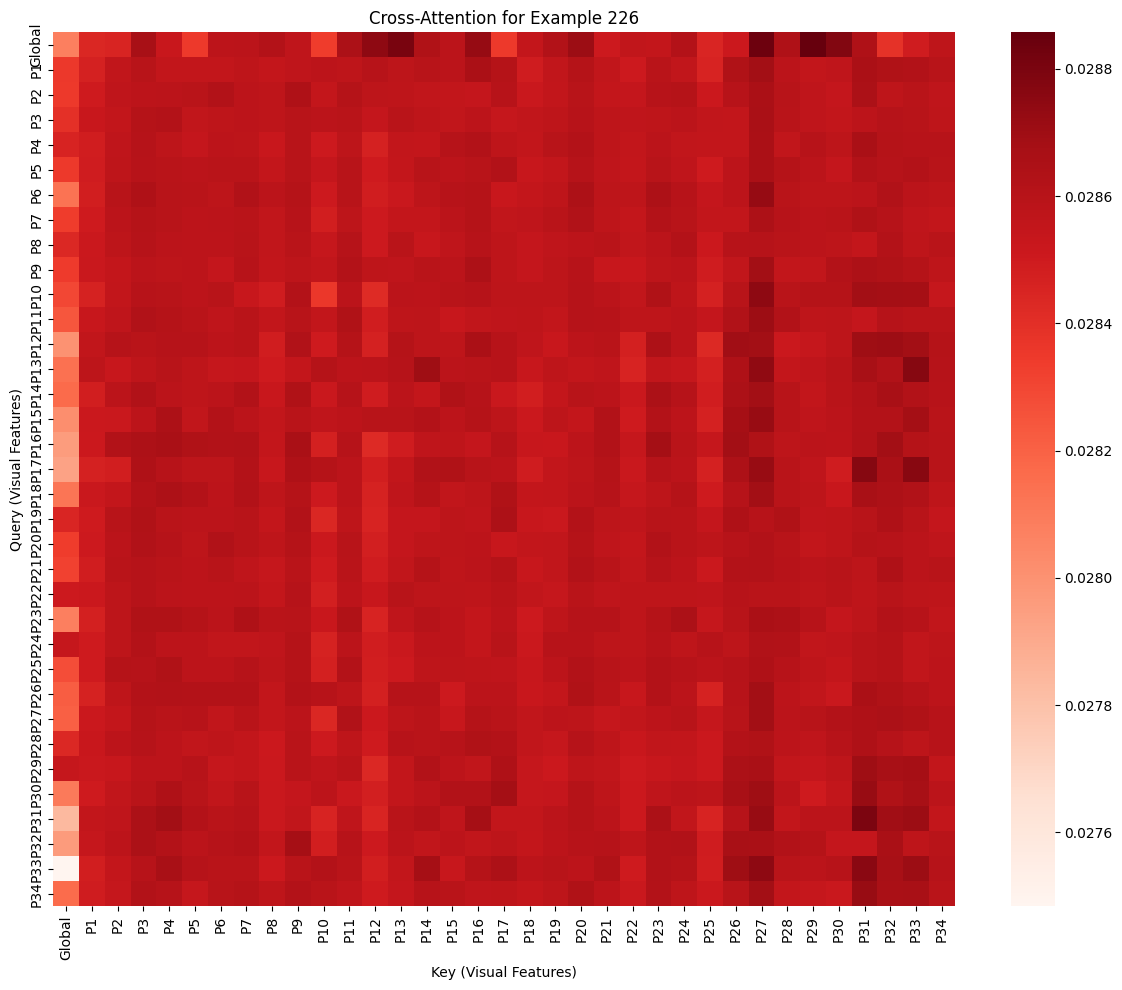

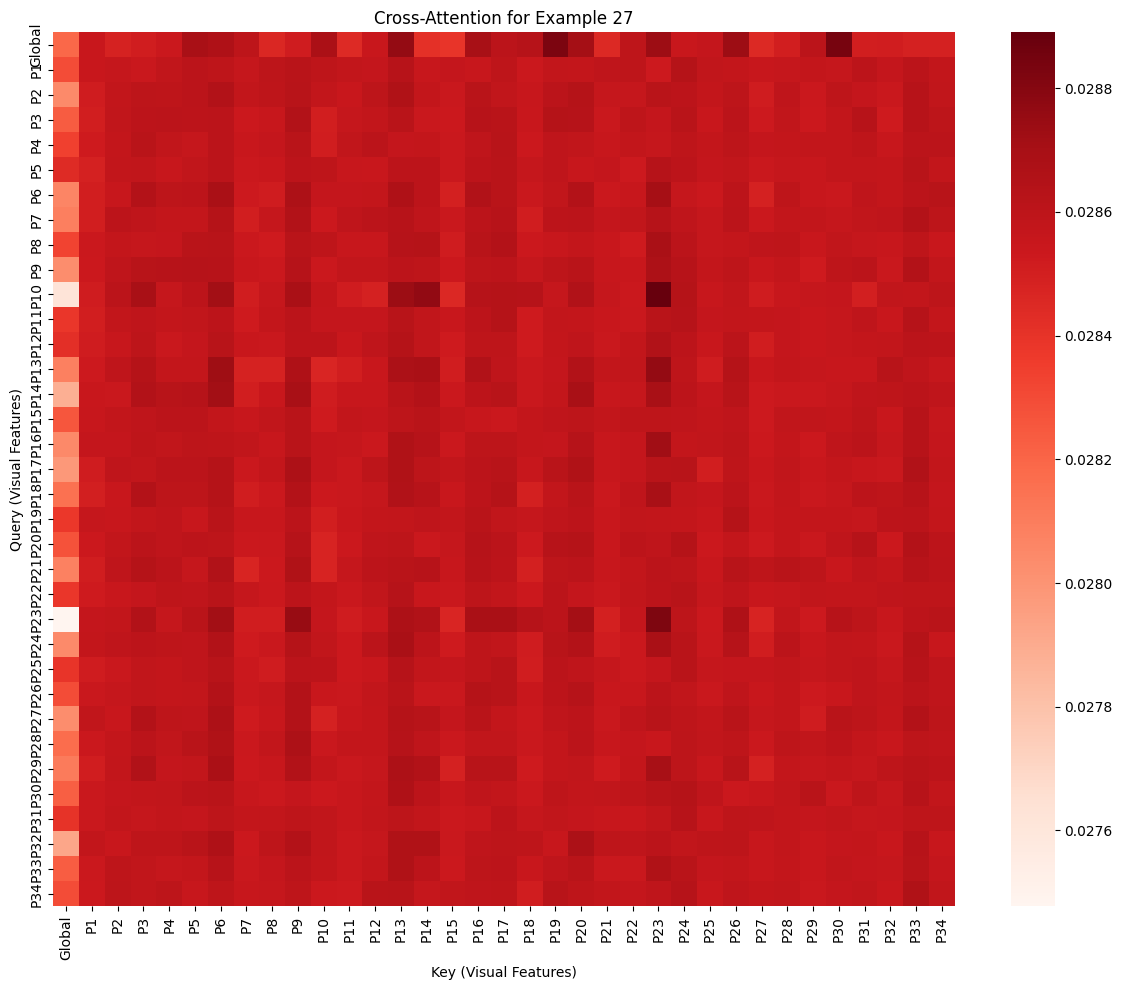

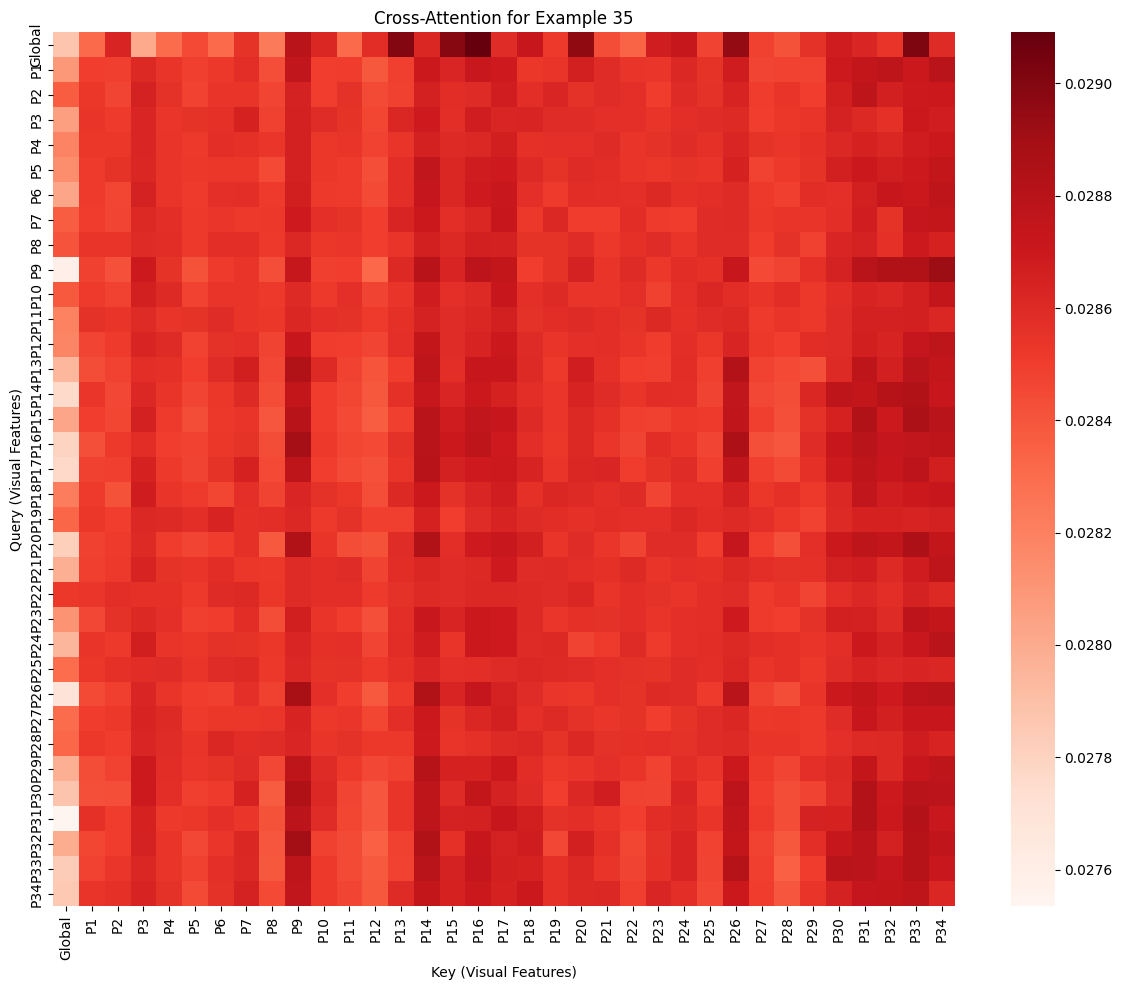

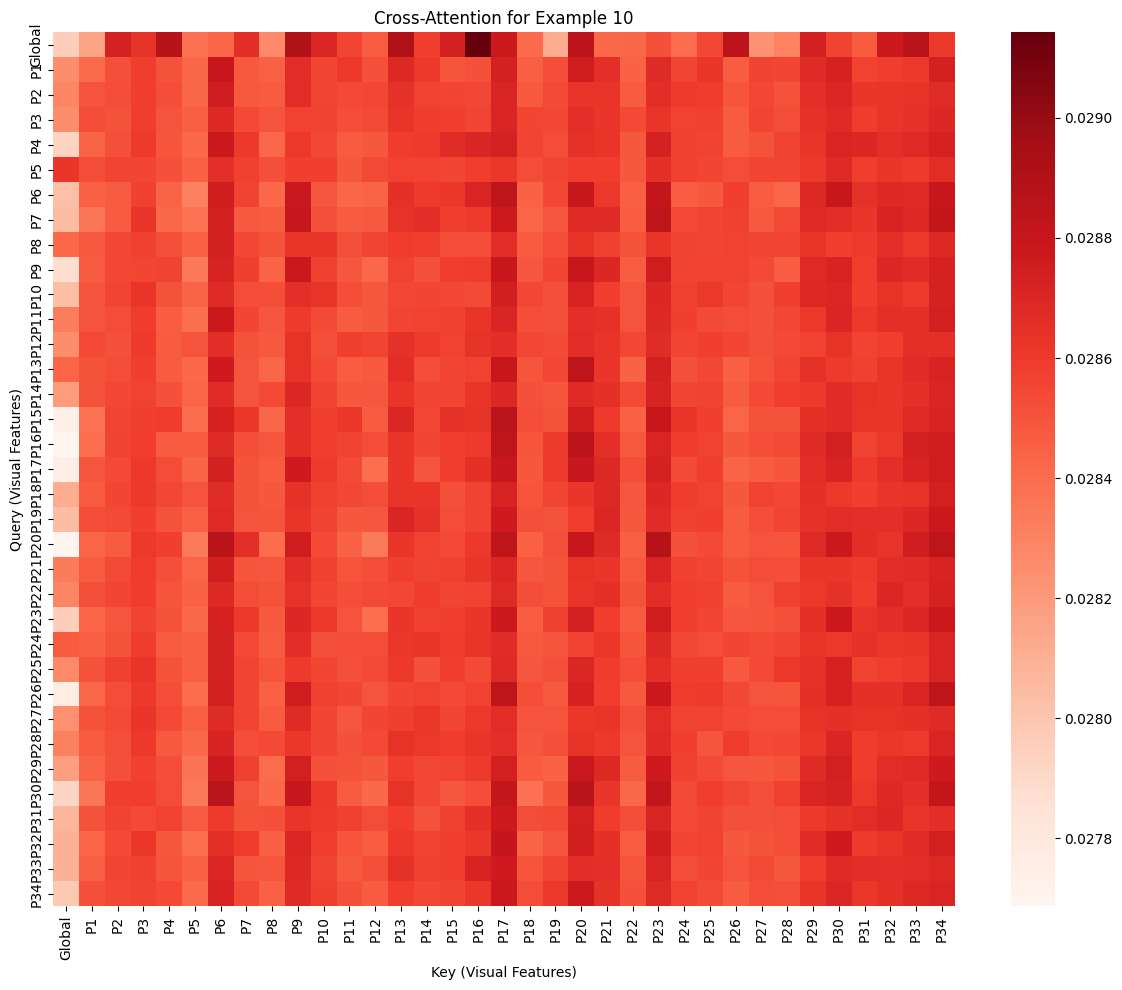

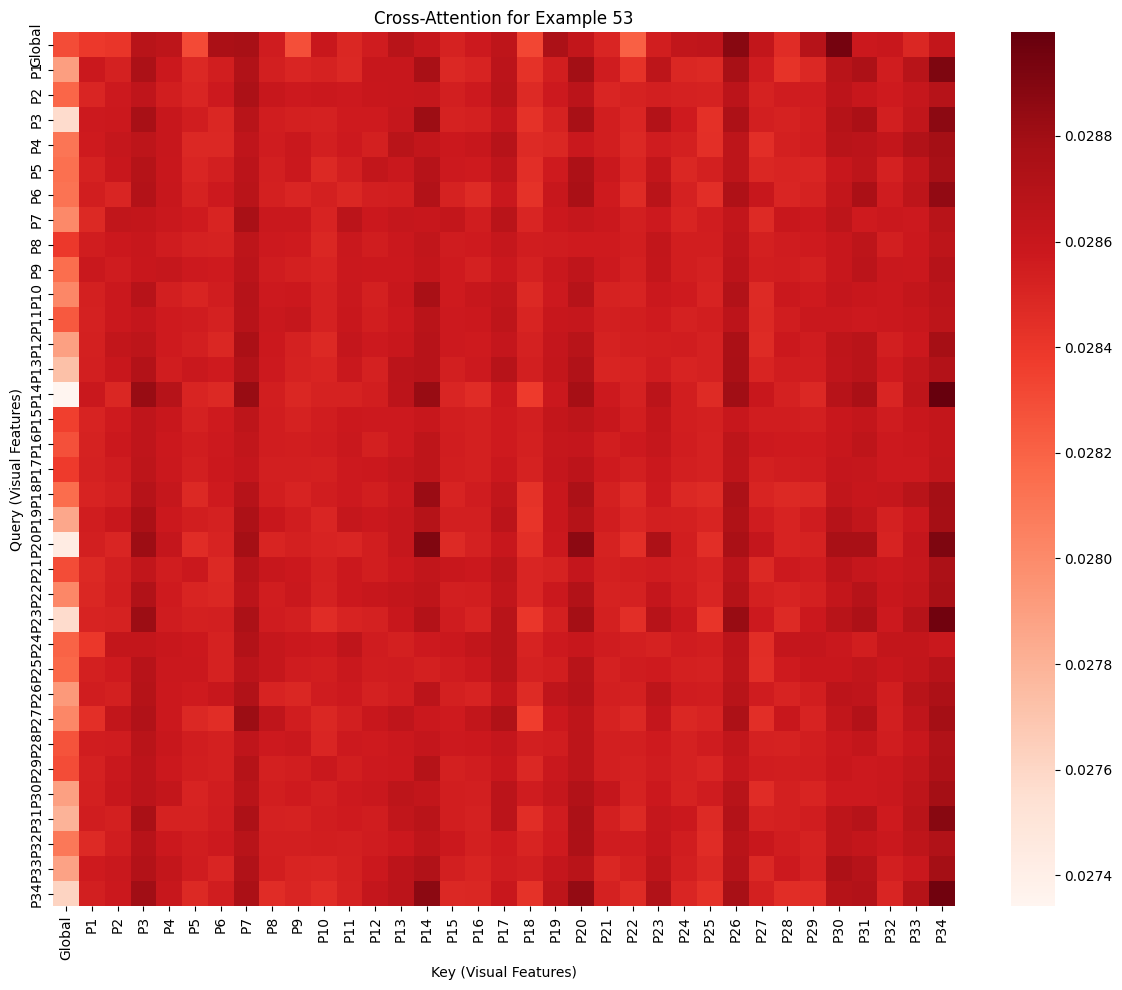


Visualizing decoder cross-attention...


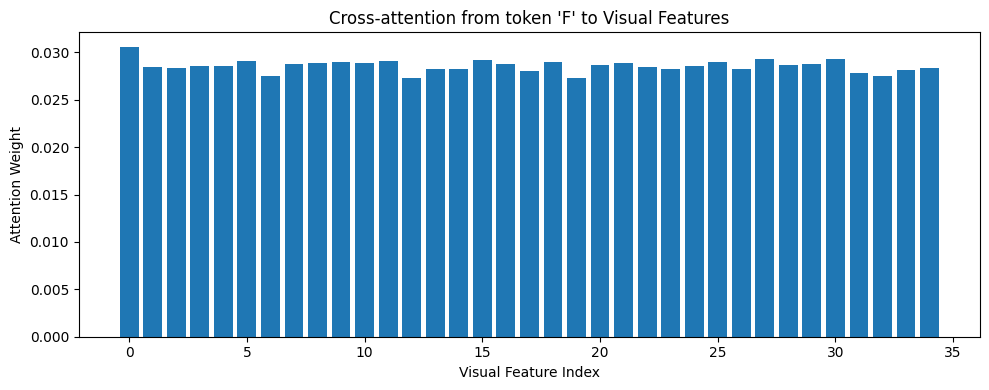


--- Example 159 ---
Raw Report       : 
[ Finding ]_x000D_
possible gout, left big toe._x000D_
[ Conclusion ]_x000D_
possible gout, left big toe._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
possible gout, left big toe.
Generated Report : 
FINDINGS: degenerative change. 

--- Example 176 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Conclusion ]_x000D_
No bony abnormalities._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
No bony abnormalities.
Generated Report : 
FINDINGS: Rt. ankle soft tissue swelling, Lt 2nd MTP joint -> RA involvement 

--- Example 12 ---
Raw Report       : 
[ Finding ]_x000D_
Lt. tibiotalar joint effusion and soft tissue swelling._x000D_
    --> R/O acute gout._x000D_
both accessory navicular bone, type III_x000D_
Lt. distal fibular tip, fragmentation_x000D_
  --> R/O old fracture._x000D_
_x000D_
[ Diagnosis ]_x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Lt. tibiotalar joint effusion and soft tissue swelling. --> R/O acute gout. both acce

In [24]:
import os
import re
import json
import unicodedata
import random
import logging
import seaborn as sns
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# LoRA imports
from peft import LoraConfig, get_peft_model, TaskType

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions (unchanged)
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms (unchanged)
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

def visualize_attention(attn_weights, title="Attention Weights", filename=None):
    """
    Visualize attention weights as a heatmap.
    
    Args:
        attn_weights: Tensor of attention weights
        title: Plot title
        filename: Optional filename to save the plot
    """
    plt.figure(figsize=(12, 10))
    
    # Convert to numpy for plotting
    attn = attn_weights.detach().cpu().numpy()

    
    # Plot heatmap
    sns.heatmap(attn, cmap="Reds")
    
    # Add labels for global image and patches
    n_features = attn.shape[0]
    feature_labels = ["Global"] + [f"P{i}" for i in range(1, n_features)]
    plt.xticks(np.arange(n_features) + 0.5, feature_labels, rotation=90)
    plt.yticks(np.arange(n_features) + 0.5, feature_labels)
    
    plt.title(title)
    plt.xlabel("Key (Visual Features)")
    plt.ylabel("Query (Visual Features)")
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.show()

def visualize_decoder_cross_attention(model, example, tokenizer, device):
    """
    Extract decoder cross-attn by doing a direct forward pass (no generate),
    so we can visualize real cross-attn weights for the 'F' in FINDINGS:.
    """
    # Prepare vision features
    fi = example['full_img'].unsqueeze(0).to(device)
    pa = example['patches'].unsqueeze(0).to(device)
    with torch.no_grad():
        g_feats = model.global_encoder(fi)
        g = model.global_proj(g_feats).unsqueeze(1)
        B,N,C,H,W = pa.shape
        p = pa.view(B*N, C, H, W)
        pf = model.patch_proj(model._pool(model.patch_encoder(p))).view(B, N, 768)
        enc_inputs = torch.cat([g, pf], dim=1)
        encoder_hidden_states = model.norm(enc_inputs)

    # Tokenize (BOS + FINDINGS:)
    toks = tokenizer(
        "FINDINGS:",
        return_tensors="pt",
        add_special_tokens=True
    ).to(device)
    input_ids = toks.input_ids
    # Make an all-ones mask over the encoder side
    encoder_attention_mask = torch.ones(
        input_ids.size(0),
        encoder_hidden_states.size(1),
        device=device
    )

    # Direct decoder forward (no generate)
    outputs = model.decoder(
        input_ids=input_ids,
        attention_mask=None,
        encoder_hidden_states=encoder_hidden_states,
        encoder_attention_mask=encoder_attention_mask,
        output_attentions=True,
        use_cache=False,
        return_dict=True
    )

    # Stack & average: (layers, B, heads, Q, K) → (B, Q, K)
    cross = torch.stack(outputs.cross_attentions, dim=0)
    cross = cross.mean(dim=0).mean(dim=1)

    # Find the “F” token index
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    token_idx = next(i for i,t in enumerate(tokens) if t.lstrip("Ġ").startswith("F"))

    # Grab and plot its attention over visual features
    attn_weights = cross[0, token_idx].detach().cpu().numpy()
    plt.figure(figsize=(10,4))
    plt.bar(np.arange(attn_weights.shape[0]), attn_weights)
    plt.xlabel("Visual Feature Index")
    plt.ylabel("Attention Weight")
    plt.title(f"Cross-attention from token '{tokens[token_idx]}' to Visual Features")
    plt.tight_layout()
    plt.show()



# =============================================================================
# Dataset (with FINDINGS: prefix in __getitem__)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        # <<<— CHANGED: prepend FINDINGS: so model learns after it
        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    # _gen_patches and _clean_report methods as before...
    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function (unchanged)
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition, with LoRA integration
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        # Base GPT-2 decoder
        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

        # Apply LoRA to decoder
        lora_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            r=16,                  # Low rank dimension
            lora_alpha=32,         # Scaling factor
            lora_dropout=0.05,     # Dropout probability
            target_modules=["c_attn", "c_proj"],  # Apply to attention modules
            bias="none"
        )
        self.decoder = get_peft_model(self.decoder, lora_config)
        print("LoRA adapters integrated into GPT-2 decoder")

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None, visualize_attn=False):
        g_feats = self.global_encoder(imgs)
        g = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                   if hasattr(self.patch_encoder, 'forward_features')
                   else self.patch_encoder(p))
        pf_pooled = self._pool(pf_feats)
        pf = self.patch_proj(pf_pooled).view(B, N, 768)

        # Modified to get attention weights with need_weights=True
        cat, attn_weights = self.attn(torch.cat([g,pf],1),
                                     torch.cat([g,pf],1),
                                     torch.cat([g,pf],1),
                                     need_weights=True)
        
        # Visualize attention if requested
        if visualize_attn:
            for b in range(min(B, 2)):  # Visualize first 2 examples maximum
                visualize_attention(
                    attn_weights[b],
                    title=f"Visual Cross-Attention (Batch {b})",
                    filename=f"visual_attention_batch_{b}.png"
                )
        
        comb = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        # Return attention weights along with model output
        return out, attn_weights

# =============================================================================
# Training & evaluation loops (unchanged decode with FINDINGS:)
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out, _ = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device, visualize_attn=True):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    visualization_done = False
    
    for b_idx, b in enumerate(tqdm(loader, desc="Evaluating", leave=False)):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            # Only visualize the first batch
            visualize_this_batch = visualize_attn and not visualization_done
            out, attn_weights = model(imgs, pts, ids, msk, decoder_labels=ids, 
                                     visualize_attn=visualize_this_batch)
            
            if visualize_this_batch:
                visualization_done = True
            
            total_loss += out.loss.item()

            # Continue with existing code for generation
            g_feats = model.global_encoder(imgs)
            g = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p = pts.view(B*N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled = model._pool(pf_feats)
            pf = model.patch_proj(pf_pooled).view(B, N, 768)
            cat, _ = model.attn(torch.cat([g,pf],1),
                              torch.cat([g,pf],1),
                              torch.cat([g,pf],1))
            comb = model.norm(cat)
            
            # <<<— CHANGED: decode with FINDINGS: prefix
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask= torch.ones_like(prompt_ids, device=device)

            gen_ids = model.decoder.generate(
                input_ids=prompt_ids,
                attention_mask=prompt_mask,
                encoder_hidden_states=comb,
                encoder_attention_mask=torch.ones(B, comb.size(1), device=device),
                max_length=150,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss/len(loader), all_gen, all_gt


def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with freeze/unfreeze
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# instantiate model (with LoRA built in)
model = MultiModalModel().to(device)

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")
    print(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

# print sample counts
print(f"\nNumber of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")
print(f"Total samples:                {len(train_ds) + len(val_ds) + len(test_ds)}\n")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# =============================================================================
# Phase 1: freeze base GPT-2 and train only LoRA + vision adapters
# =============================================================================
for name, p in model.decoder.base_model.named_parameters():
    p.requires_grad = False

for p in model.global_proj.parameters(): p.requires_grad = True
for p in model.patch_proj.parameters():  p.requires_grad = True

#  • LoRA adapters (they live in the Conv1D modules, so by un-freezing c_attn/ c_proj we pick up both self- and cross-attn)
for name, p in model.decoder.named_parameters():
    if any(substr in name for substr in ("c_attn", "c_proj", "lora")):
        p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 1
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze LoRA adapters only (keep base GPT-2 frozen)
# =============================================================================
for name, p in model.decoder.base_model.named_parameters():
    p.requires_grad = False

# 2) Freeze vision projections
for p in model.global_proj.parameters():
    p.requires_grad = False
for p in model.patch_proj.parameters():
    p.requires_grad = False

# 3) Un-freeze only the LoRA adapters (they live in model.decoder)
for name, p in model.decoder.named_parameters():
    if "lora" in name.lower():
        p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 1
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# In your test examples section, add:
print("\n========== VISUALIZING CROSS-ATTENTION ==========")
for i, idx in enumerate(random.sample(range(len(test_ds)), min(5, len(test_ds)))):
    ex = test_ds[idx]
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)

    # Extract visual features
    g_feats = model.global_encoder(fi)
    g = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p = pa.view(B*N, C, H, W)
    pf_feats = model.patch_encoder(p)
    pf_pooled = model._pool(pf_feats)
    pf = model.patch_proj(pf_pooled).view(B,N,768)
    
    # Get attention weights and visualize
    cat, attn_weights = model.attn(
        torch.cat([g,pf],1),
        torch.cat([g,pf],1),
        torch.cat([g,pf],1),
        need_weights=True
    )
    
    visualize_attention(
        attn_weights[0],  # First batch item
        title=f"Cross-Attention for Example {idx}",
        filename=f"example_{idx}_attention.png"
    )
    
    # Continue with existing code...
# Add to your test section
print("\nVisualizing decoder cross-attention...")
example_idx = random.choice(range(len(test_ds)))
visualize_decoder_cross_attention(model, test_ds[example_idx], tokenizer, device)


# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    # build visual context
    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    # generate after FINDINGS: prompt
    prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask= torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")
